In [1]:
import sys
sys.path.append('/home/mila/l/leo.gagnon/latent_control')

%load_ext autoreload
%autoreload 2
from lightning_modules.metalearn import MetaLearningTask
import torch
import matplotlib.pyplot as plt
import pyvene as pv

# Compute KL curve

In [2]:
task = MetaLearningTask('y9qwghft')
task.to('cuda');

Loaded dataset : (11288/1000)
Loaded checkpoing : last.ckpt


In [3]:
task.full_data.cfg.tag

'small'

In [21]:
data = task.full_data

ids = torch.randperm(len(data))
train_ids = ids[:60000][torch.randint(0,60000,(200000,))]
val_ids = ids[60000:]
val_ids = val_ids[torch.randint(0,len(val_ids),(50000,))]

train_data = data.__getitems__(train_ids, length=200)['input_ids']
val_data = data.__getitems__(val_ids, length=200)['input_ids']

73728

In [22]:
res = task.evaluate_pp(samples=10, n_steps=200)

10it [00:07,  1.43it/s]


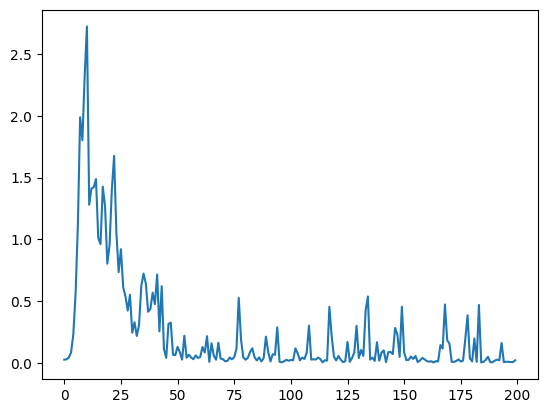

In [23]:
plt.plot(res['BackwardKL'].mean(0))

# Extract hidden states with pyvene

In [6]:
task.model.config.ssm_cfg = dict(task.model.config.ssm_cfg)
task.model.config = PretrainedConfig.from_dict(dataclasses.asdict(task.model.config))

In [18]:
all_ids = torch.arange(len(task.full_data))
some_ids = torch.randperm(len(task.full_data))[:100]

In [23]:
repr_configs = [
    pv.RepresentationConfig(
        component=f"backbone.layers[{i}].mixer.output",
        intervention=pv.CollectIntervention(embed_dim=384, keep_last_dim=True),
    )
    for i in range(6)
]
intv_model = pv.IntervenableModel(pv.IntervenableConfig(repr_configs), model=task.model)

/home/mila/l/leo.gagnon/latent_control/data/hmm.py:595: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  intv_envs = jnp.array(intv_envs)
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:4252: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=bool(copy), order=order, device=device)


In [26]:
input_ids = task.full_data.__getitems__(torch.repeat_interleave(some_ids,100), length=300)['input_ids']
latents = []
for batch in tqdm(torch.chunk(input_ids, 100)):
    intv_out = intv_model(
        base=BatchEncoding({"input_ids": batch, "only_last_logits": False}),
        unit_locations={"sources->base": [[[i for i in range(300)]]]},
    )
    latents += [torch.stack(list(intv_out[0][1].values()),-2)[:, [0,9,19,29,39,49,99,199,299]].cpu()]

100%|██████████| 100/100 [00:26<00:00,  3.72it/s]
